# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=10,000 patients, with 5 covariate $Z_p$ ($p \in [1,...,5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in [1,...,d]$. Here, we choose $d=30$. <br> <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1,...,M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
For each of the samples, we sample it's time-to-event $T_i$ from the hazard function $\lambda_{j}(T|Z) = \frac{exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+exp(\alpha_{jt}+Z^{T}\beta_{j})}$ such that <br>
$\alpha_{1t} = -1-0.3 log(t)$ <br> 
$\beta_{1} = -log([0.8, 3, 3, 2.5, 2])$ <br> 
$\alpha_{2t} = -1.75-0.15 log(t)$ <br> 
$\beta_{2} = -log([1, 3, 4, 3, 2])$ <br> 

and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, ... , d]$. <br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
n_patients = 50000
n_cov = 5
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
30836,30836,0.963039,0.862514,0.151403,0.013899,0.520010,1,1,6,1
30046,30046,0.727934,0.810600,0.400967,0.264497,0.405388,0,30,3,3
3462,3462,0.522687,0.114368,0.003367,0.573465,0.459525,0,21,8,8
16725,16725,0.738827,0.445443,0.347225,0.366962,0.670616,1,8,20,8
35944,35944,0.477982,0.883097,0.002242,0.772298,0.155511,0,30,3,3


## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, ... , T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [3]:
from pydts.fitters import DataExpansionFitter
fitter = DataExpansionFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()



Model summary for event: 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    j_1   No. Observations:               358588
Model:                            GLM   Df Residuals:                   358553
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54055.
Date:                Tue, 15 Mar 2022   Deviance:                   1.0811e+05
Time:                        18:49:34   Pearson chi2:                 3.58e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01552
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(X)[1]       -0.9880  

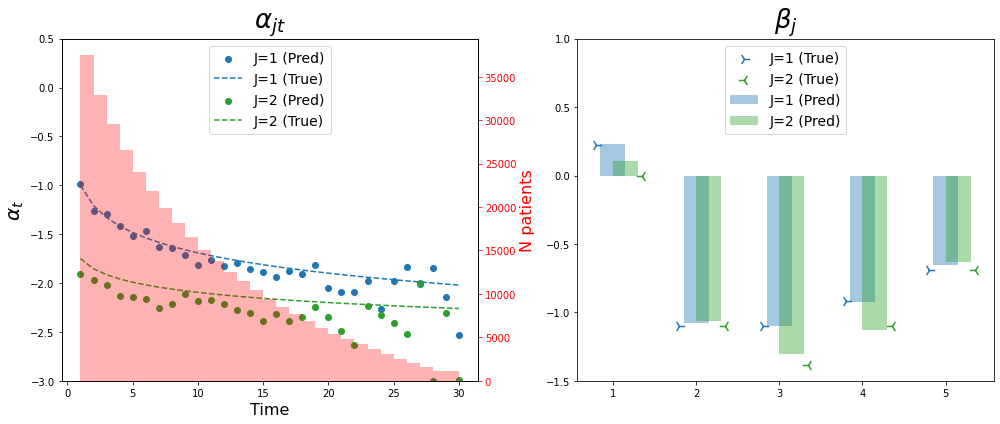

In [4]:
from pydts.examples_utils.plots import plot_first_model_coefs
plot_first_model_coefs(models=fitter.event_models, times=times, expanded_train_df=fitter.expanded_df, 
                       n_cov=5)

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [5]:
from pydts.fitters import TwoStagesFitter
fitter = TwoStagesFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 358588 total observations, 345290 right-censored observations>
             duration col = 'X'
                event col = 'j_1'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 358588
number of events observed = 13298
   partial log-likelihood = -130518.14
         time fit was run = 2022-03-15 16:50:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.22       1.25       0.03             0.16             0.28                 1.18                 1.33
Z2         -1.05       0.35       0.03            -1.11            -0.99                 0.33                 0.37
Z3         -1.07       0.34       0.03            -1.13            -1.01                 0.32                 0.36
Z4         -0.90       0.41       0.03            -0.96            -0.84                 0.38                 0.43
Z5         -0.64       0.53       0.03            -0.69            -0.58                 0.50                 0.56

               z      p   -log2(p)
covariate                         
Z1          7.43 <0.005      43.02
Z2        -34.29 <0.005     853.48
Z3        -34.93 <0.005     885.65
Z4        -29.49 <0.005     632.71
Z5        -21.02 <0.005     323.50
---
Concordance = 0.65
Partial AIC = 261046.28
log-likelihood ratio test = 3561.38 on 5 df
-log2(p) of ll-ratio test = inf

None


n_jt  success  alpha_jt
J X                          
1 1   2550     True -1.029241
  2   1686     True -1.303201
  3   1431     True -1.338009
  4   1130     True -1.453891
  5    902     True -1.564685
  6    847     True -1.514501
  7    651     True -1.672507
  8    575     True -1.689521
  9    482     True -1.762430
  10   393     True -1.864172
  11   376     True -1.806400
  12   318     True -1.871830
  13   296     True -1.837627
  14   249     True -1.902313
  15   217     True -1.931007
  16   185     True -1.981903
  17   175     True -1.921255
  18   151     True -1.950647
  19   145     True -1.863748
  20   101     True -2.102667
  21    85     True -2.137559
  22    74     True -2.140406
  23    71     True -2.016904
  24    45     True -2.311729
  25    49     True -2.022763
  26    45     True -1.887726
  27    29     True -2.058930
  28    24     True -1.899775
  29    12     True -2.191885
  30     4    False  0.000000



Model summary for event: 2


<lifelines.CoxPHFitter: fitted with 358588 total observations, 352834 right-censored observations>
             duration col = 'X'
                event col = 'j_2'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 358588
number of events observed = 5754
   partial log-likelihood = -55924.25
         time fit was run = 2022-03-15 16:50:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.11       1.11       0.05             0.02             0.20                 1.02                 1.22
Z2         -1.05       0.35       0.05            -1.14            -0.96                 0.32                 0.38
Z3         -1.29       0.28       0.05            -1.38            -1.19                 0.25                 0.30
Z4         -1.12       0.33       0.05            -1.21            -1.03                 0.30                 0.36
Z5         -0.62       0.54       0.05            -0.71            -0.53                 0.49                 0.59

               z      p   -log2(p)
covariate                         
Z1          2.38   0.02       5.83
Z2        -22.69 <0.005     376.24
Z3        -27.45 <0.005     548.54
Z4        -24.01 <0.005     420.61
Z5        -13.57 <0.005     136.97
---
Concordance = 0.66
Partial AIC = 111858.50
log-likelihood ratio test = 1922.02 on 5 df
-log2(p) of ll-ratio test = inf

None


n_jt  success  alpha_jt
J X                          
2 1    874     True -1.919152
  2    694     True -1.981768
  3    575     True -2.043460
  4    455     True -2.147943
  5    399     True -2.156424
  6    348     True -2.178896
  7    283     True -2.266610
  8    264     True -2.226806
  9    262     True -2.127554
  10   219     True -2.198283
  11   199     True -2.191869
  12   172     True -2.231112
  13   146     True -2.283395
  14   127     True -2.309618
  15   105     True -2.381227
  16   101     True -2.317188
  17    83     True -2.386184
  18    77     True -2.346615
  19    75     True -2.251659
  20    59     True -2.349619
  21    45     True -2.500990
  22    34     True -2.637033
  23    43     True -2.245095
  24    33     True -2.331362
  25    25     True -2.403960
  26    18     True -2.534024
  27    23     True -2.018925
  28     6     True -2.976584
  29     8     True -2.325888
  30     2    False  0.000000

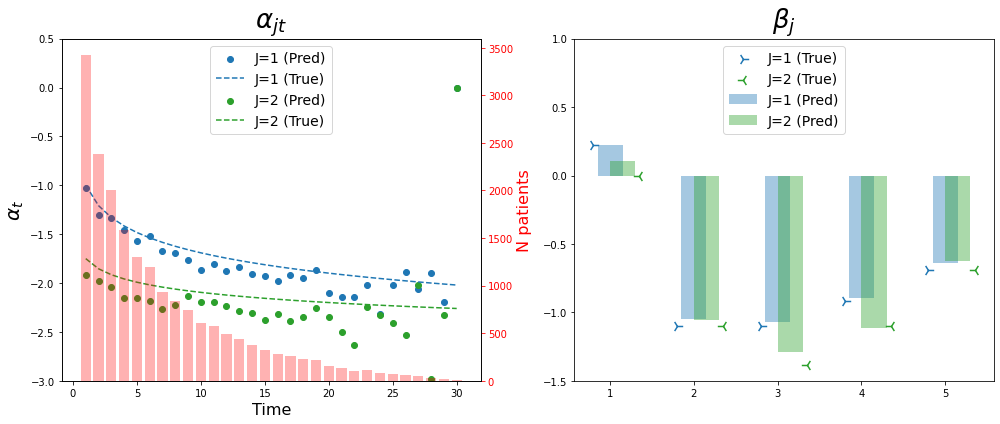

In [6]:
from pydts.examples_utils.plots import plot_second_model_coefs
plot_second_model_coefs(fitter.alpha_df, fitter.beta_models, times, n_cov=5)

In [7]:
fitter.get_beta_SE()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.223032,0.030034,0.108418,0.045643
Z2,-1.046514,0.030521,-1.052748,0.046395
Z3,-1.069749,0.030624,-1.286462,0.046870
Z4,-0.896712,0.030403,-1.117006,0.046531
Z5,-0.635528,0.030232,-0.623618,0.045949


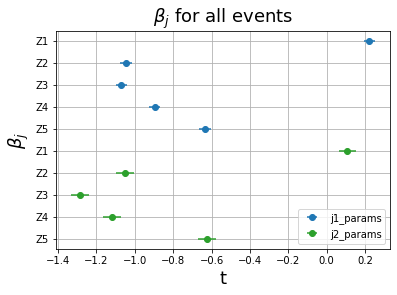

<AxesSubplot:title={'center':'$\\beta_{j}$ for all events'}, xlabel='t', ylabel='$\\beta_{j}$'>

In [8]:
fitter.plot_all_events_beta()

## Prediction

In [9]:
pred_df = fitter.predict_cumulative_incident_function(test_df)
pred_df = fitter.predict_marginal_prob_all_events(pred_df)
pred_df.set_index(['pid']).head().T

pid,27909,43124,48015,40407,48981
Z1,5.541054e-01,1.637635e-01,4.887498e-01,7.921766e-01,9.815248e-01
Z2,6.248929e-01,7.175472e-01,5.819794e-01,6.591445e-01,4.024318e-01
Z3,6.806733e-02,4.223119e-02,9.307777e-01,2.003877e-01,2.039507e-01
Z4,6.788034e-01,8.311016e-03,3.491959e-01,9.312432e-01,2.235817e-01
Z5,9.166018e-01,5.930816e-01,8.688099e-01,7.120194e-01,6.133019e-01
J,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
T,1.300000e+01,3.000000e+01,3.000000e+01,4.000000e+00,1.000000e+00
C,1.100000e+01,2.000000e+01,6.000000e+00,1.100000e+01,1.000000e+00
X,1.100000e+01,2.000000e+01,6.000000e+00,4.000000e+00,1.000000e+00
X_copy,1.100000e+01,2.000000e+01,6.000000e+00,4.000000e+00,1.000000e+00


## Comparison (WIP)

In [10]:
pd.DataFrame(index=pd.MultiIndex.from_product([['d=30', 'd=60', 'd=100', 'd=150'],
                                               ['N=1000', 'N=10000', 'N=100000']], names=['N', 'D']), 
             columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

Train MSE (oracle) Test MSE (oracle) computation time
N     D                                                             
d=30  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=60  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=100 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=150 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN